In [1]:
import numpy as np
import pandas as pd
from numpy import linalg
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
def oneHotEncoding(arr):
    r = np.zeros((len(arr),10))
    for n in range(len(arr)):
        r[n][int(arr[n])] = 1
    return r

def softmax_act(input):
    input_vector = input
    num = np.exp(input_vector)
    den = np.sum(np.exp(input_vector), axis=0)
    softmax = num / den
    c = input_vector
    return softmax, c

def relu_act(input):
    relu = np.maximum(0, input)
    assert (relu.shape == input.shape)
    c = input
    return relu, c

def sigmoid_act(input):
    input_vector = input
    den = 1 + np.exp(-input_vector)
    sigmoid = 1 / den
    c = input_vector
    return sigmoid, c

In [3]:
def random_no(x,y):
    r = np.random.randn(x,y)
    return r

def set_params_3Layers(i, h, o):
    np.random.seed(1)
    k = random_no(h, i)
    Weight1 = k * 0.01
    bias1 = np.zeros((h, 1))
    k = random_no(h, h)
    Weight2 = k * 0.01
    bias2 = np.zeros((h, 1))
    k = random_no(o, h)
    Weight3 = k * 0.01
    bias3 = np.zeros((o, 1))
    assert (Weight1.shape == (h, i))
    assert (bias1.shape == (h, 1))
    assert (Weight2.shape == (h, h))
    assert (bias2.shape == (h, 1))
    assert (Weight3.shape == (o, h))
    assert (bias3.shape == (o, 1))
    params = {"W1": Weight1,"b1": bias1,"W2": Weight2,"b2": bias2,"W3": Weight3,"b3": bias3}
    return params

In [4]:
def set_params(i, h, o):
    np.random.seed(1)
    k = random_no(h,i)
    Weight1 = k * 0.01
    bias1 = np.zeros((h, 1))
    k = random_no(o,h)
    Weight2 = k * 0.01
    bias2 = np.zeros((o, 1))
    assert (Weight1.shape == (h, i))
    assert (bias1.shape == (h, 1))
    assert (Weight2.shape == (o, h))
    assert (bias2.shape == (o, 1))
    params = {"W1": Weight1,"b1": bias1,"W2": Weight2,"b2": bias2}
    return params

In [5]:
def forward(input, Weight, bias):
    z = np.dot(Weight, input) 
    o = z + bias
    assert (o.shape == (Weight.shape[0], input.shape[1]))
    c = (input, Weight, bias)
    return o, c

def lr_act_for(input, Weight, bias, activation_function):
    if activation_function == "softmax":
        N, l_c = forward(input, Weight, bias)
        S, a_c = softmax_act(N)
    elif activation_function == "relu":
        N, l_c = forward(input, Weight, bias)
        S, a_c = relu_act(N)
    elif activation_function == "sigmoid":
        N, l_c = forward(input, Weight, bias)
        S, a_c = sigmoid_act(N)
    assert (S.shape == (Weight.shape[0], input.shape[1]))
    c = (l_c, a_c)
    return S, c

In [6]:
def calculate_cost(X, Y):
    n = Y.shape[1]
    k = np.sum(Y * np.log(X))
    f = float(n)
    c = -k / f
    assert (c.shape == ())
    return c


In [7]:
def backward(der, c):
    input, Weight, bias = c
    k = input.shape[1]
    i = np.dot(der, input.T)
    j = float(k)
    derW = i / j
    n = np.sum(der, axis=1, keepdims=True)
    derb =  n / j
    derin = np.dot(Weight.T, der)
    assert (derin.shape == input.shape)
    assert (derW.shape == Weight.shape)
    assert (derb.shape == bias.shape)
    return derin, derW, derb

def relu_act_backward(der, c):
    i = c
    di = np.array(der, copy=True)
    di[i <= 0] = 0
    assert (di.shape == i.shape)
    return di

def sigmoid_act_backward(O, c):
    i = c
    z = 1 + np.exp(-i)
    s = 1 / z
    di = np.subtract(s, O)
    assert (di.shape == i.shape)
    return di

def softmax_act_backward(O, c):
    k = c
    i = np.exp(k)
    j = np.sum(np.exp(k), axis=0)
    s = i / j 
    dk = np.subtract(s, O)
    assert (dk.shape == k.shape)
    return dk

In [8]:
def lr_act_back(dI, c, activation_function):
    l_c, a_c = c
    if activation_function == "relu":
        dZ = relu_act_backward(dI, a_c)
        dI_prev, dW, db = backward(dZ, l_c)
    elif activation_function == "softmax":
        dZ = softmax_act_backward(dI, a_c)
        dI_prev, dW, db = backward(dZ, l_c)
    elif activation_function == "sigmoid":
        dZ = sigmoid_act_backward(dI, a_c)
        dI_prev, dW, db = backward(dZ, l_c)
    return dI_prev, dW, db


In [9]:
def update_params(params, gradients, learning_rate):
    L = len(params) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(1, L + 1):
        params['W' + str(l)] -= learning_rate * gradients['dW' + str(l)]
        params['b' + str(l)] -= learning_rate * gradients['db' + str(l)]
    return params



In [10]:
def three_layer_model(X, Y, dims, learning_rate=0.001, iterations=200, cost=False):
    np.random.seed(1)
    gradients = {}
    costs = []
    m = X.shape[1]
    (nx, nh, ny) = dims
    params = set_params_3Layers(nx, nh, ny)
    Weight1 = params["W1"]
    bias1 = params["b1"]
    Weight2 = params["W2"]
    bias2 = params["b2"]
    Weight3 = params["W3"]
    bias3 = params["b3"]
 
    for i in range(0, iterations):
        # Forward_propagation
        S1, c1 = lr_act_for(X, Weight1, bias1, activation_function='relu')
        S2, c2 = lr_act_for(S1, Weight2, bias2, activation_function='relu')
        #A3, cache3 = lr_act_for(A2, W3, b3, activation='softmax')
        S3, c3 = lr_act_for(S2, Weight3, bias3, activation_function='softmax')
        cost1 = calculate_cost(S3, Y)
        # Backward_propagation
        
        #dA2, dW3, db3 = lr_act_back(Y, cache3, activation='softmax')
        dS2, dWeight3, dbias3 = lr_act_back(Y, c3, activation_function='softmax')
        dS1, dWeight2, dbias2 = lr_act_back(dS2, c2, activation_function='relu')
        dS0, dWeight1, dbias1 = lr_act_back(dS1, c1, activation_function='relu')
        
        gradients['dW1'] = dWeight1
        gradients['db1'] = dbias1
        gradients['dW2'] = dWeight2
        gradients['db2'] = dbias2
        gradients['dW3'] = dWeight3
        gradients['db3'] = dbias3
        
        params = update_params(params, gradients, learning_rate)
        Weight1 = params["W1"]
        bias1 = params["b1"]
        Weight2 = params["W2"]
        bias2 = params["b2"]
        Weight3 = params["W3"]
        bias3 = params["b3"]
    return params


In [11]:
def two_layer_model(X, Y, dims, learning_rate=0.001, iterations=200, cost=False):
    np.random.seed(1)
    gradients = {}
    costs = []
    m = X.shape[1]
    (nx, nh, ny) = dims
    params = set_params(nx, nh, ny)
    
    Weight1 = params["W1"]
    bias1 = params["b1"]
    Weight2 = params["W2"]
    bias2 = params["b2"]
 
    for i in range(0, iterations):
        
        S1, c1 = lr_act_for(X, Weight1, bias1, activation_function='relu')
        S2, c2 = lr_act_for(S1, Weight2, bias2, activation_function='softmax')
        
        cost1 = calculate_cost(S2, Y)
        
        dS1, dWeight2, dbias2 = lr_act_back(Y, c2, activation_function='softmax')
        dA0, dWeight1, dbias1 = lr_act_back(dS1, c1, activation_function='relu')
        gradients['dW1'] = dWeight1
        gradients['db1'] = dbias1
        gradients['dW2'] = dWeight2
        gradients['db2'] = dbias2
        
        params = update_params(params, gradients, learning_rate)
        Weight1 = params["W1"]
        bias1 = params["b1"]
        Weight2 = params["W2"]
        bias2 = params["b2"]
    return params


In [12]:
def predict(X, y, params):
    m = X.shape[1]
    Weight1 = params["W1"]
    bias1 = params["b1"]
    Weight2 = params["W2"]
    bias2 = params["b2"]
    K1, _ = lr_act_for(X, Weight1, bias1, activation_function='relu')
    ps, _ = lr_act_for(K1, Weight2, bias2, activation_function='softmax')
    pdt = np.argmax(ps, axis=0)
    num = np.sum(pdt == y)
    pd = np.round(num * 100 / len(pdt))
    return pd

In [13]:
def predicted_Y(X, y, parameters):
    m = X.shape[1]
    Weight1 = parameters["W1"]
    bias1 = parameters["b1"]
    Weight2 = parameters["W2"]
    bias2 = parameters["b2"]
    A1, _ = lr_act_for(X, Weight1, bias1, activation_function='relu')
    probs, _ = lr_act_for(A1, Weight2, bias2, activation_function='softmax')
    predicted = np.argmax(probs, axis=0)
    return predicted


In [14]:
def predicted_Y_3Layer(X, y, parameters):
    m = X.shape[1]
    Weight1 = parameters["W1"]
    bias1 = parameters["b1"]
    Weight2 = parameters["W2"]
    bias2 = parameters["b2"]
    Weight3 = parameters["W3"]
    bias3 = parameters["b3"]
    
    A1, _ = lr_act_for(X, Weight1, bias1, activation_function='relu')
    probs, _ = lr_act_for(A1, Weight2, bias2, activation_function='relu')
    probs1, _ = lr_act_for(probs, Weight3, bias3, activation_function='softmax')
    
    predicted = np.argmax(probs1, axis=0)
    return predicted


In [15]:
def predict_3Layer(X, y, parameters):
    m = X.shape[1]
    Weight1 = parameters["W1"]
    bias1 = parameters["b1"]
    Weight2 = parameters["W2"]
    bias2 = parameters["b2"]
    Weight3 = parameters["W3"]
    bias3 = parameters["b3"]
    
    A1, _ = lr_act_for(X, Weight1, bias1, activation_function='relu')
    probs, _ = lr_act_for(A1, Weight2, bias2, activation_function='relu')
    probs1, _ = lr_act_for(probs, Weight3, bias3, activation_function='softmax')
    
    predicted = np.argmax(probs1, axis=0)
    correct_num = np.sum(predicted == y)
    return np.round(correct_num * 100 / len(predicted))

# Read data

In [16]:
data_30sec = pd.read_csv("features_30_sec.csv", delimiter=",")
data_3sec = pd.read_csv("features_3_sec.csv", delimiter=",")
data_30sec.drop('filename',axis=1,inplace=True)
data_3sec.drop('filename',axis=1,inplace=True)
label = LabelEncoder()
data_30sec['label_cat'] = label.fit_transform(data_30sec[['label']])
data_3sec['label_cat'] = label.fit_transform(data_3sec[['label']])
data_30sec = data_30sec.drop('label', axis=1)
data_3sec = data_3sec.drop('label', axis=1)
data_30sec.fillna(0)
data_3sec.fillna(0)
data_30sec = np.array(data_30sec)
data_3sec = np.array(data_3sec)

c:\Python\Python36\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Python36\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
sc30sec = StandardScaler().fit_transform(data_30sec[:,:-1])
sc3sec = StandardScaler().fit_transform(data_3sec[:,:-1])

In [18]:
h,w = data_30sec.shape
y30 = []
y3 = []
for i,j in enumerate(data_30sec):
    y30.append(data_30sec[i][w-1])
    h,w = data_3sec.shape
for i,j in enumerate(data_3sec):
    y3.append(data_3sec[i][w-1])


# Split data into train, test and validation

In [19]:
Xtrain30sec, Xtest30sec, ytrain30sec, ytest30sec = train_test_split(sc30sec, y30, test_size=0.2, random_state=1)
Xtrain30sec, Xval30sec, ytrain30sec, Yval30sec = train_test_split(Xtrain30sec, ytrain30sec, test_size=0.25, random_state=1)

In [20]:
ytrain30sec = np.array(ytrain30sec)
ytrain30sec_oh = oneHotEncoding(ytrain30sec)

# Two layer model

# 30 second scratch

In [21]:
n = [10,20,30,40,50,60,70,80,90,100,110,120]
accuracies = []
lrates = []
for nodes in n:
    predstt30sec = []
    predstr30sec = []
    rates = []
    learning_rate = 0.001
    epochs = 200
    while learning_rate <= 1:
        params = two_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
        ytest30sec = np.array(ytest30sec)
        ytrain30sec = np.array(ytrain30sec)
        predtest30sec = predict(Xtest30sec.T, ytest30sec.T, params)
        predtrain30sec = predict(Xtrain30sec.T, ytrain30sec.T, params)
        predstt30sec.append(predtest30sec)
        predstr30sec.append(predtrain30sec)
        rates.append(learning_rate)
        learning_rate=learning_rate*1.5
    print("Optimal Learning Rate:", rates[np.argmax(predstt30sec)])
    params = two_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes, 10),rates[np.argmax(predstt30sec)], epochs, True)
    predtest30sec = predict(Xtest30sec.T, ytest30sec.T, params)
    print("No of Epochs: ", epochs)
    print("Model used: Two layer model")
    print("No of hidden layer nodes: ", nodes)
    print("Test accuracy: ", predtest30sec, "%")
    accuracies.append(predtest30sec)
    lrates.append(rates[np.argmax(predstt30sec)])

Optimal Learning Rate: 0.43789389038085935
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  10
Test accuracy:  64.0 %
Optimal Learning Rate: 0.43789389038085935
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  20
Test accuracy:  69.0 %
Optimal Learning Rate: 0.43789389038085935
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  30
Test accuracy:  70.0 %
Optimal Learning Rate: 0.29192926025390625
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  40
Test accuracy:  68.0 %
Optimal Learning Rate: 0.43789389038085935
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  50
Test accuracy:  69.0 %
Optimal Learning Rate: 0.43789389038085935
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  60
Test accuracy:  70.0 %
Optimal Learning Rate: 0.656840835571289
No of Epochs:  200
Model used: Two layer model
No of hidden layer nodes:  70
Test accuracy:  70.0 %
O

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Accuracy at Epochs =200')

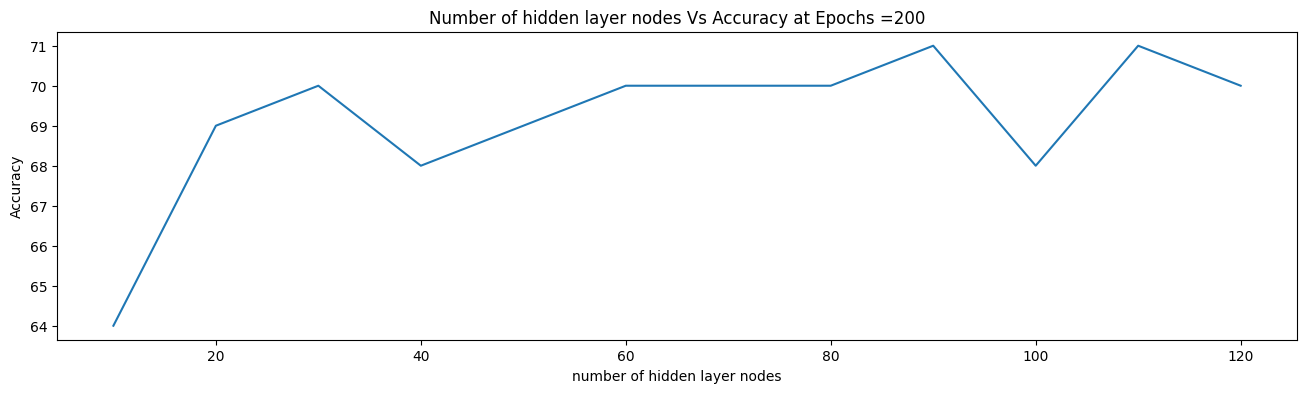

In [22]:
plt.xlabel("number of hidden layer nodes")
plt.ylabel("Accuracy")
plt.plot(n,accuracies)
plt.title('Number of hidden layer nodes Vs Accuracy at Epochs =200')

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

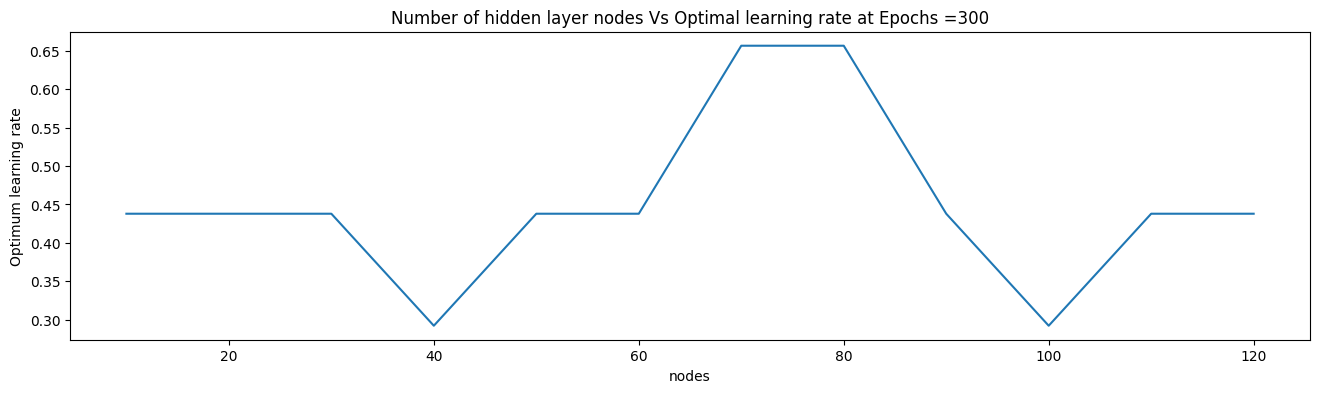

In [23]:
plt.ylabel("Optimum learning rate")
plt.xlabel("nodes")
plt.plot(n,lrates)
plt.title('Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

Text(0.5, 1.0, 'Learning rate vs Accuracy for 30 second data file (Two layer model scratch, Number of hidden nodes = 90, Epochs = 200))')

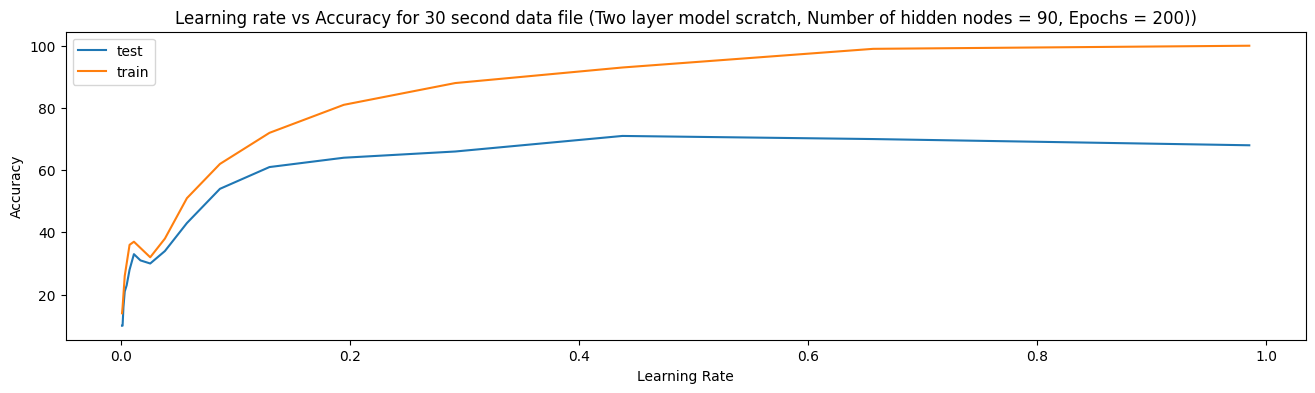

In [24]:
predstt30sec = []
predstr30sec = []
rates = []
learning_rate = 0.001
epochs = 200
nodes =  90
while learning_rate <= 1:
    params = two_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
    ytest30sec = np.array(ytest30sec)
    ytrain30sec = np.array(ytrain30sec)
    predtest30sec = predict(Xtest30sec.T, ytest30sec.T, params)
    predtrain30sec = predict(Xtrain30sec.T, ytrain30sec.T, params)
    predstt30sec.append(predtest30sec)
    predstr30sec.append(predtrain30sec)
    rates.append(learning_rate)
    learning_rate=learning_rate*1.5
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt30sec)
plt.plot(rates,predstr30sec)
plt.legend(['test','train'])
plt.title('Learning rate vs Accuracy for 30 second data file (Two layer model scratch, Number of hidden nodes = 90, Epochs = 200))')

#################Optimal Learning Rate: 0.43789389038085935#####################333

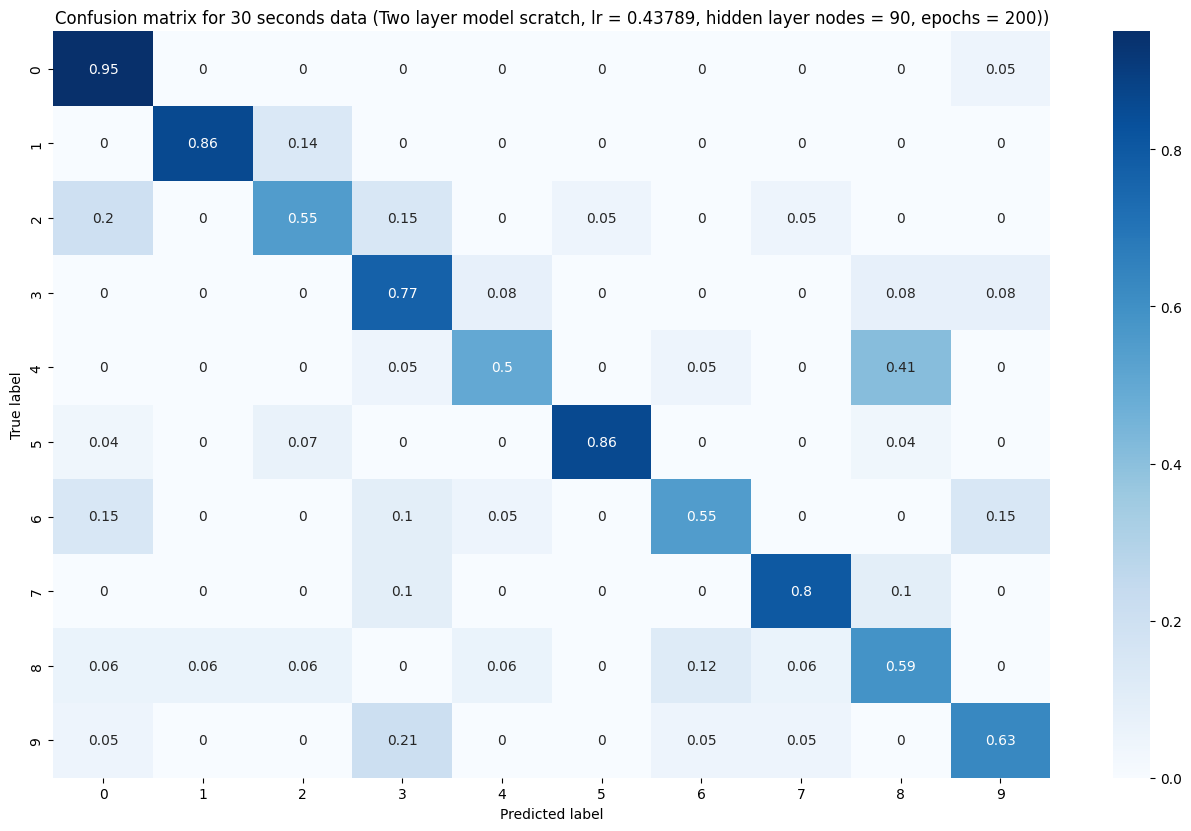

In [25]:
#Optimized parameters for 30 secs data for two layer model
learning_rate = 0.43789389038085935
epochs = 200
nodes =  90
params = two_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
ytest30sec = np.array(ytest30sec)
ytrain30sec = np.array(ytrain30sec)
Ypredicted_test30 = predicted_Y(Xtest30sec.T, ytest30sec.T, params)
Ypredicted_train30 = predicted_Y(Xtrain30sec.T, ytrain30sec.T, params)

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest30sec,Ypredicted_test30,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 30 seconds data (Two layer model scratch, lr = 0.43789, hidden layer nodes = 90, epochs = 200))')
plt.show()

# Three layer model

In [26]:
#n = [10,20,30,40,50,60,70,80,90,100,110,120,130]
n = [80,90]
accuracies = []
lrates = []
for nodes in n:
    predstt30sec = []
    predstr30sec = []
    rates = []
    learning_rate = 0.001
    epochs = 300
    while learning_rate <= 1:
        params = three_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
        ytest30sec = np.array(ytest30sec)
        ytrain30sec = np.array(ytrain30sec)
        predtest30sec = predict_3Layer(Xtest30sec.T, ytest30sec.T, params)
        predtrain30sec = predict_3Layer(Xtrain30sec.T, ytrain30sec.T, params)
        predstt30sec.append(predtest30sec)
        predstr30sec.append(predtrain30sec)
        rates.append(learning_rate)
        learning_rate=learning_rate*1.5
    print("Optimal Learning Rate:", rates[np.argmax(predstt30sec)])
    params = three_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes, 10),rates[np.argmax(predstt30sec)], epochs, True)
    predtest30sec = predict_3Layer(Xtest30sec.T, ytest30sec.T, params)
    print("Number of Epochs: ", epochs)
    print("Model used: Three layer model")
    print("Number of hidden layer nodes: ", nodes)
    print("Test accuracy: ", predtest30sec, "%")
    accuracies.append(predtest30sec)
    lrates.append(rates[np.argmax(predstt30sec)])

Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Three layer model
Number of hidden layer nodes:  80
Test accuracy:  70.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Three layer model
Number of hidden layer nodes:  90
Test accuracy:  72.0 %


Text(0.5, 1.0, 'Number of hidden layer nodes Vs Accuracy at Epochs =300')

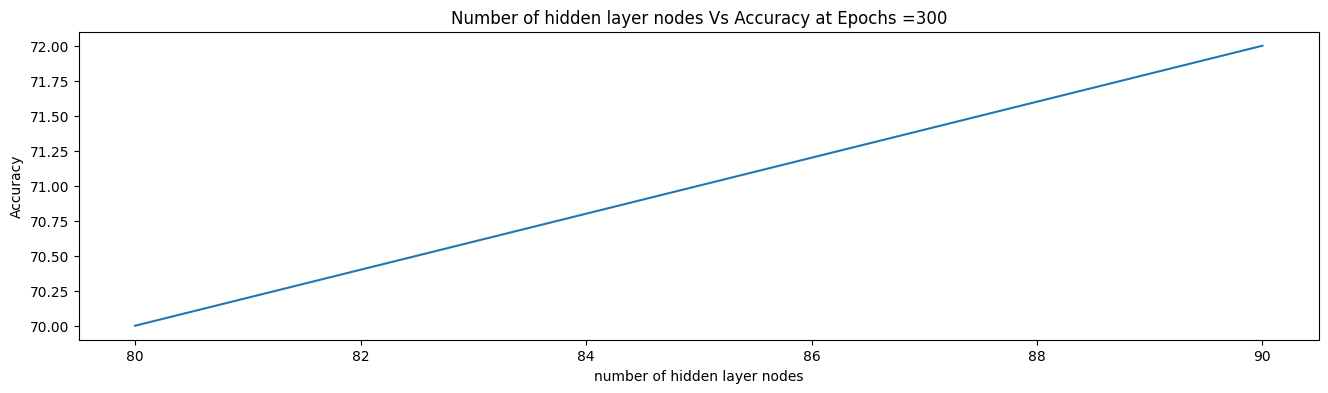

In [27]:
plt.xlabel("number of hidden layer nodes")
plt.ylabel("Accuracy")
plt.plot(n,accuracies)
plt.title('Number of hidden layer nodes Vs Accuracy at Epochs =300')

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

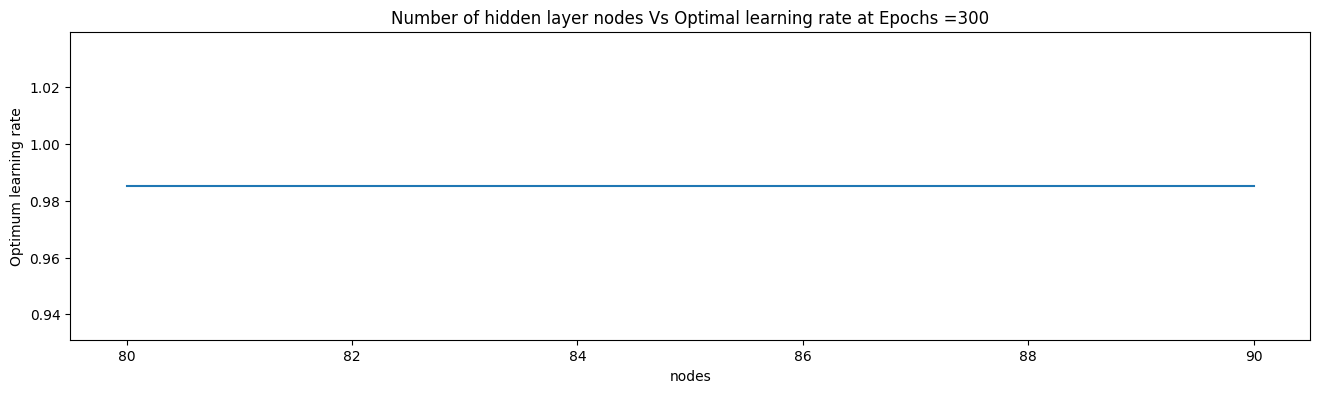

In [28]:
plt.ylabel("Optimum learning rate")
plt.xlabel("nodes")
plt.plot(n,lrates)
plt.title('Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

Text(0.5, 1.0, 'Learning rate vs Accuracy for 30 second data file (Three layer model scratch, hidden layer nodes = 90, epochs = 300))')

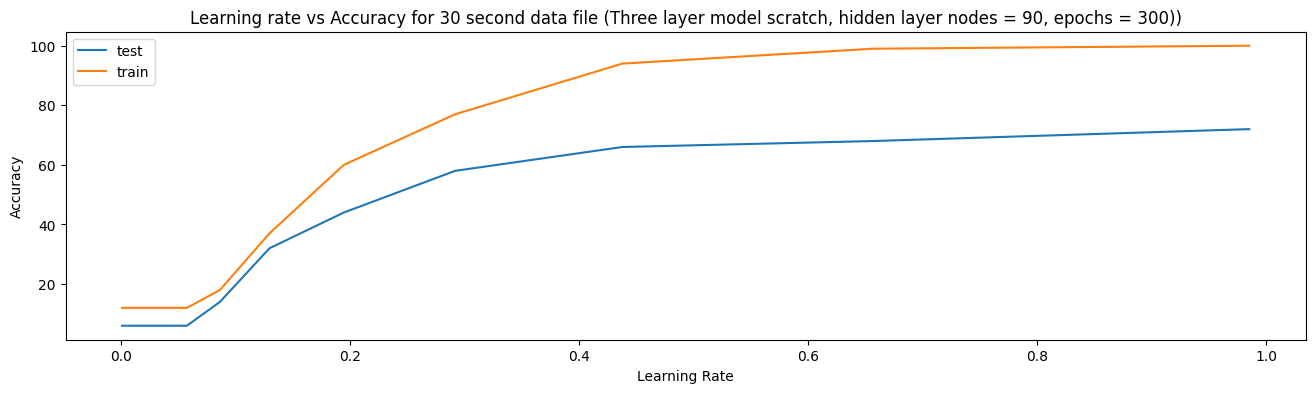

In [29]:
predstt30sec = []
predstr30sec = []
rates = []
learning_rate = 0.001
epochs = 300
nodes =  90
while learning_rate <= 1:
    params = three_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
    ytest30sec = np.array(ytest30sec)
    ytrain30sec = np.array(ytrain30sec)
    predtest30sec = predict_3Layer(Xtest30sec.T, ytest30sec.T, params)
    predtrain30sec = predict_3Layer(Xtrain30sec.T, ytrain30sec.T, params)
    predstt30sec.append(predtest30sec)
    predstr30sec.append(predtrain30sec)
    rates.append(learning_rate)
    learning_rate*=1.5
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt30sec)
plt.plot(rates,predstr30sec)
plt.legend(['test','train'])
plt.title('Learning rate vs Accuracy for 30 second data file (Three layer model scratch, hidden layer nodes = 90, epochs = 300))')

#################Optimal Learning Rate: 0.9852612533569336#####################333

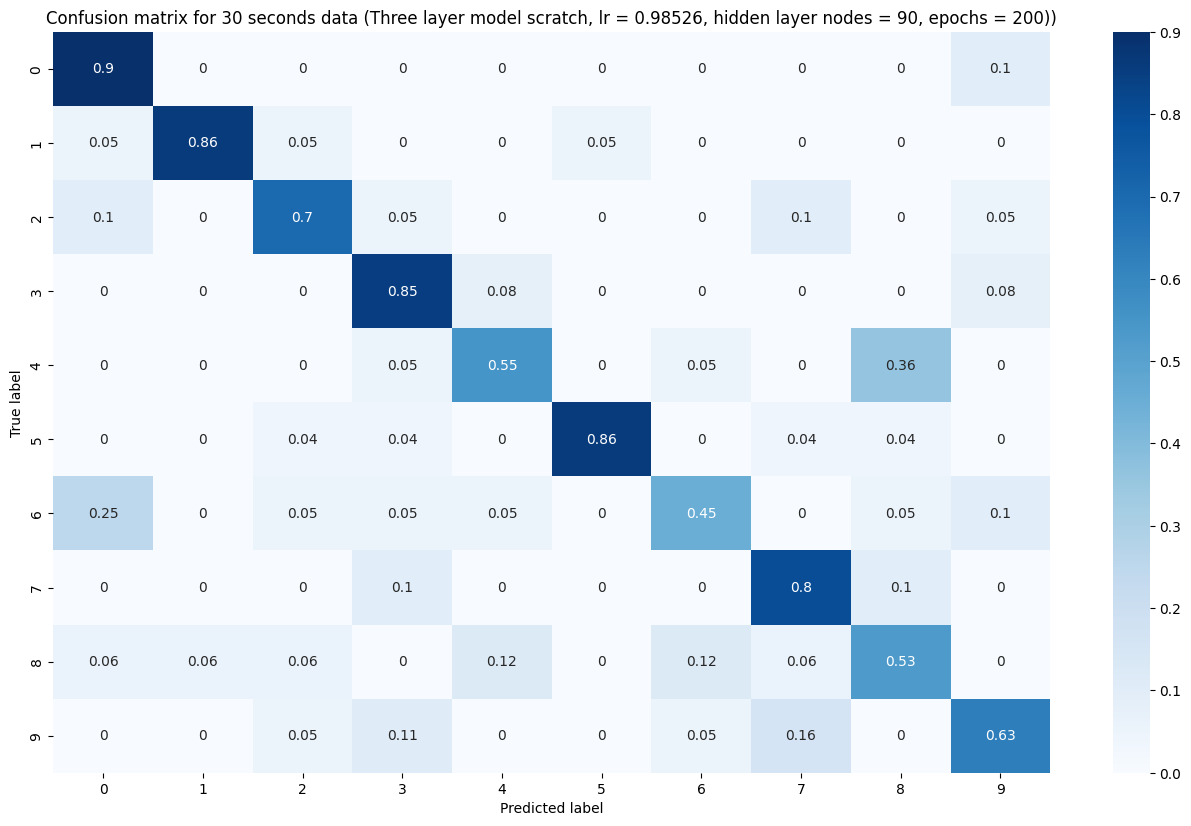

In [30]:
#Optimized parameters for 30 secs data for two layer model
learning_rate = 0.9852612533569336
epochs = 300
nodes =  90
params = three_layer_model(Xtrain30sec.T, ytrain30sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
ytest30sec = np.array(ytest30sec)
ytrain30sec = np.array(ytrain30sec)
Ypredicted_test30 = predicted_Y_3Layer(Xtest30sec.T, ytest30sec.T, params)
Ypredicted_train30 = predicted_Y_3Layer(Xtrain30sec.T, ytrain30sec.T, params)

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest30sec,Ypredicted_test30,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 30 seconds data (Three layer model scratch, lr = 0.98526, hidden layer nodes = 90, epochs = 200))')
plt.show()

# SKlearn for 30 second data

c:\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


30 Second Dataset:
Test Accuracy:  73.0 %
Train Accuracy:  100.0 %
Optimal Learning Rate Based on Test Accuracy:  0.025628906250000003
Number of Iterations:  200


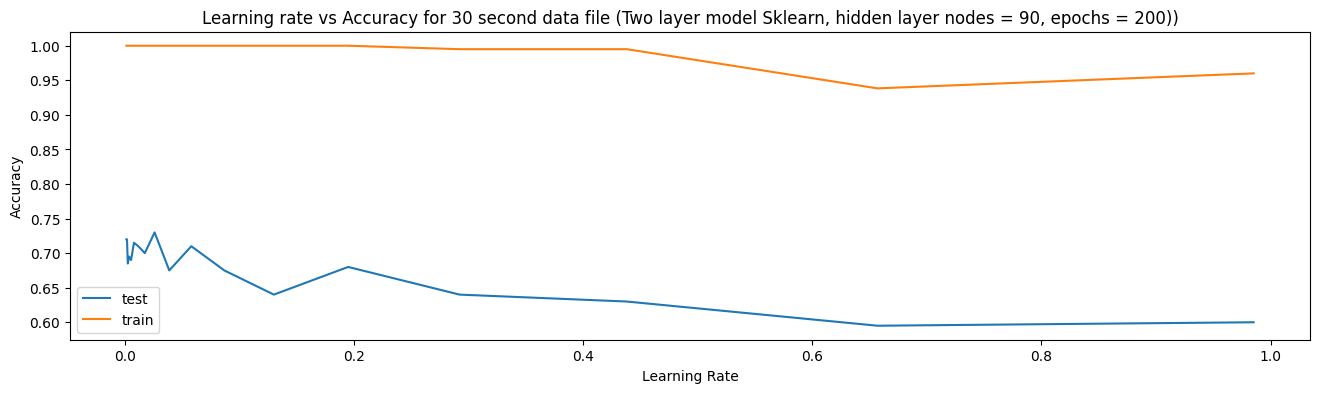

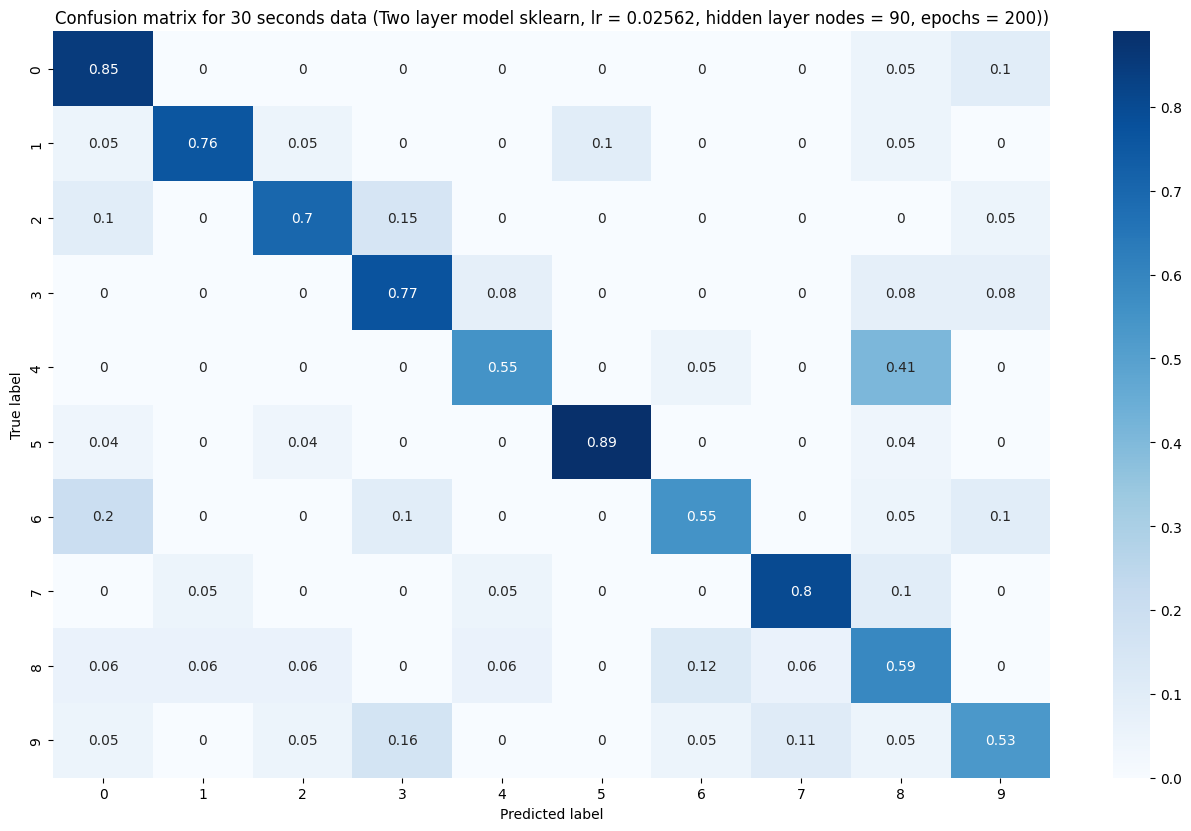

In [31]:
from sklearn.neural_network import MLPClassifier
predstt30sec = []
predstr30sec = []
rates = []
learning_rate = 0.001
while learning_rate <= 1:
    mlp = MLPClassifier(hidden_layer_sizes=(90),learning_rate_init = learning_rate, max_iter = 200)
    mlp.fit(Xtrain30sec,ytrain30sec)
    predtest30sec = mlp.predict(Xtest30sec) 
    predtrain30sec = mlp.predict(Xtrain30sec) 
    predstt30sec.append(accuracy_score(ytest30sec,predtest30sec))
    predstr30sec.append(accuracy_score(ytrain30sec,predtrain30sec))
    rates.append(learning_rate)
    learning_rate*=1.5
    
mlp = MLPClassifier(hidden_layer_sizes=(90),learning_rate_init = rates[np.argmax(predstt30sec)], max_iter = 200)
mlp.fit(Xtrain30sec,ytrain30sec)
prediction = mlp.predict(Xtest30sec)
print("30 Second Dataset:")
print("Test Accuracy: ", predstt30sec[np.argmax(predstt30sec)]*100, "%")
print("Train Accuracy: ", predstr30sec[np.argmax(predstr30sec)]*100, "%")
print("Optimal Learning Rate Based on Test Accuracy: ", rates[np.argmax(predstt30sec)])
print("Number of Iterations: ", str(200))


plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt30sec)
plt.plot(rates,predstr30sec)
plt.legend(['test','train'])

plt.title('Learning rate vs Accuracy for 30 second data file (Two layer model Sklearn, hidden layer nodes = 90, epochs = 200))')



mlp = MLPClassifier(hidden_layer_sizes=(90),learning_rate_init = rates[np.argmax(predstt30sec)], max_iter = 200)
mlp.fit(Xtrain30sec,ytrain30sec)
prediction = mlp.predict(Xtest30sec)


figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest30sec,prediction,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 30 seconds data (Two layer model sklearn, lr = 0.02562, hidden layer nodes = 90, epochs = 200))')
plt.show()

30 Second Dataset:
Test Accuracy:  71.5 %
Train Accuracy:  100.0 %
Optimal Learning Rate Based on Test Accuracy:  0.0015
Number of Iterations:  300


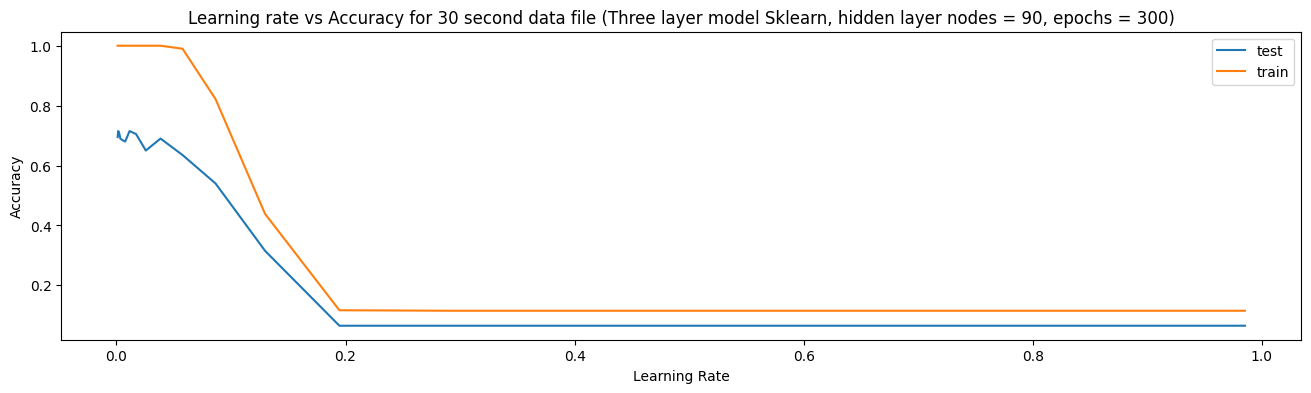

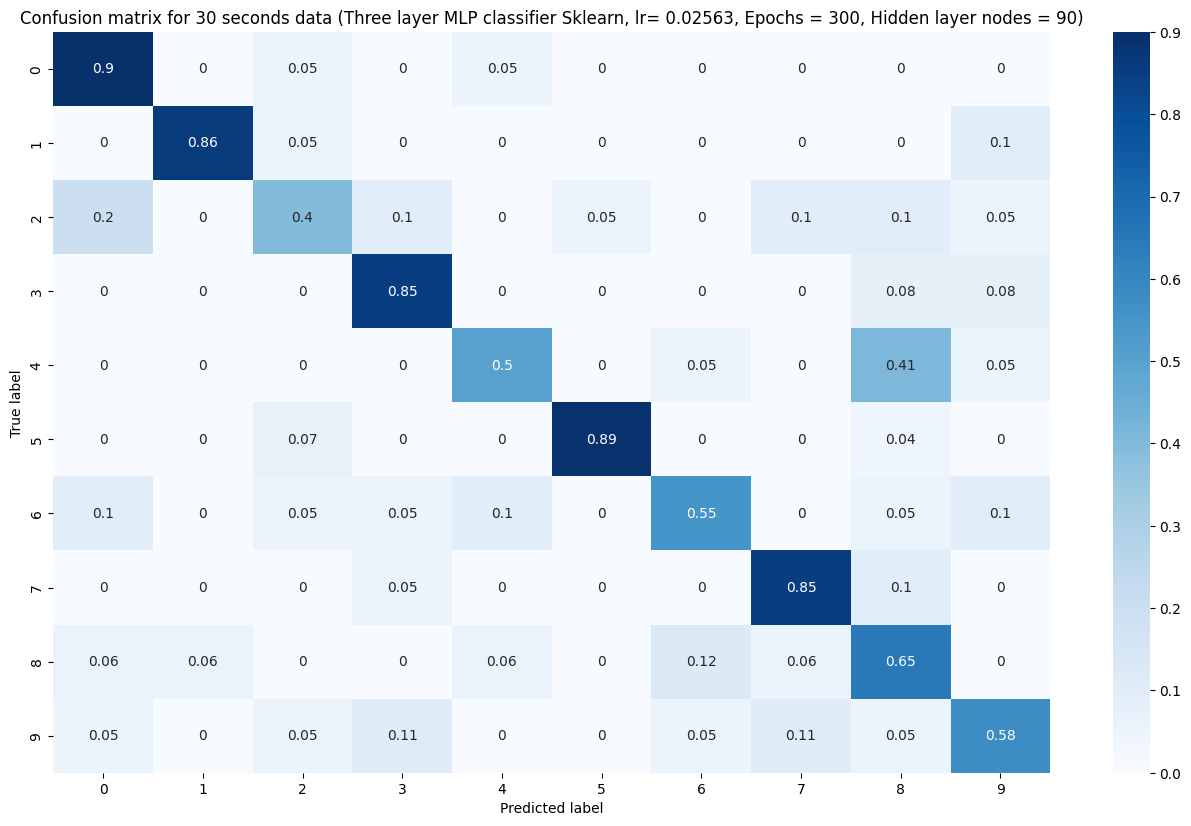

In [32]:
from sklearn.neural_network import MLPClassifier
predstt30sec = []
predstr30sec = []
rates = []
learning_rate = 0.001
while learning_rate <= 1:
    mlp = MLPClassifier(hidden_layer_sizes=(90,90),learning_rate_init = learning_rate, max_iter = 300)
    mlp.fit(Xtrain30sec,ytrain30sec)
    predtest30sec = mlp.predict(Xtest30sec) 
    predtrain30sec = mlp.predict(Xtrain30sec) 
    predstt30sec.append(accuracy_score(ytest30sec,predtest30sec))
    predstr30sec.append(accuracy_score(ytrain30sec,predtrain30sec))
    rates.append(learning_rate)
    learning_rate*=1.5
    
mlp = MLPClassifier(hidden_layer_sizes=(90,90),learning_rate_init = rates[np.argmax(predstt30sec)], max_iter = 300)
mlp.fit(Xtrain30sec,ytrain30sec)
prediction = mlp.predict(Xtest30sec)
print("30 Second Dataset:")
print("Test Accuracy: ", predstt30sec[np.argmax(predstt30sec)]*100, "%")
print("Train Accuracy: ", predstr30sec[np.argmax(predstr30sec)]*100, "%")
print("Optimal Learning Rate Based on Test Accuracy: ", rates[np.argmax(predstt30sec)])
print("Number of Iterations: ", str(300))


plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt30sec)
plt.plot(rates,predstr30sec)
plt.legend(['test','train'])
plt.title('Learning rate vs Accuracy for 30 second data file (Three layer model Sklearn, hidden layer nodes = 90, epochs = 300)')


mlp = MLPClassifier(hidden_layer_sizes=(90,90),learning_rate_init = rates[np.argmax(predstt30sec)], max_iter = 300)
mlp.fit(Xtrain30sec,ytrain30sec)
prediction = mlp.predict(Xtest30sec)


figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest30sec,prediction,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 30 seconds data (Three layer MLP classifier Sklearn, lr= 0.02563, Epochs = 300, Hidden layer nodes = 90)')
plt.show()

# 3 seonds data sratch

In [33]:
Xtrain3sec, Xtest3sec, ytrain3sec, ytest3sec = train_test_split(sc3sec, y3, test_size=0.2, random_state=1)
Xtrain3sec, Xval3sec, ytrain3sec, yval3sec = train_test_split(Xtrain3sec, ytrain3sec, test_size=0.25, random_state=1)

In [34]:
ytrain3sec = np.array(ytrain3sec)
ytrain3sec_oh = oneHotEncoding(ytrain3sec)

# Parameter tuning

In [35]:
n = [10,20,30,40,50,60,70,80,90,100,110,120]
accuracies = []
lrates = []
for nodes in n:
    predstt3sec = []
    predstr3sec = []
    rates = []
    learning_rate = 0.001
    epochs = 300
    while learning_rate <= 1:
        params = two_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
        ytest3sec = np.array(ytest3sec)
        ytrain3sec = np.array(ytrain3sec)
        predtest3sec = predict(Xtest3sec.T, ytest3sec.T, params)
        predtrain3sec = predict(Xtrain3sec.T, ytrain3sec.T,params)
        predstt3sec.append(predtest3sec)
        predstr3sec.append(predtrain3sec)
        rates.append(learning_rate)
        learning_rate*=1.5
    print("Optimal Learning Rate:", rates[np.argmax(predstt3sec)])
    params = two_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes, 10),rates[np.argmax(predstt3sec)], epochs, True)
    predtest3sec = predict(Xtest3sec.T, ytest3sec.T, params)
    print("Number of Epochs: ", epochs)
    print("Model used: Two layer model")
    print("Number of hidden layer nodes: ", nodes)
    print("Test accuracy: ", predtest3sec, "%")
    accuracies.append(predtest3sec)
    lrates.append(rates[np.argmax(predstt3sec)])

Optimal Learning Rate: 0.43789389038085935
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  10
Test accuracy:  71.0 %
Optimal Learning Rate: 0.656840835571289
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  20
Test accuracy:  77.0 %
Optimal Learning Rate: 0.656840835571289
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  30
Test accuracy:  78.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  40
Test accuracy:  79.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  50
Test accuracy:  81.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Two layer model
Number of hidden layer nodes:  60
Test accuracy:  81.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  300
Model used: Two layer model
Number o

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Accuracy at Epochs =300')

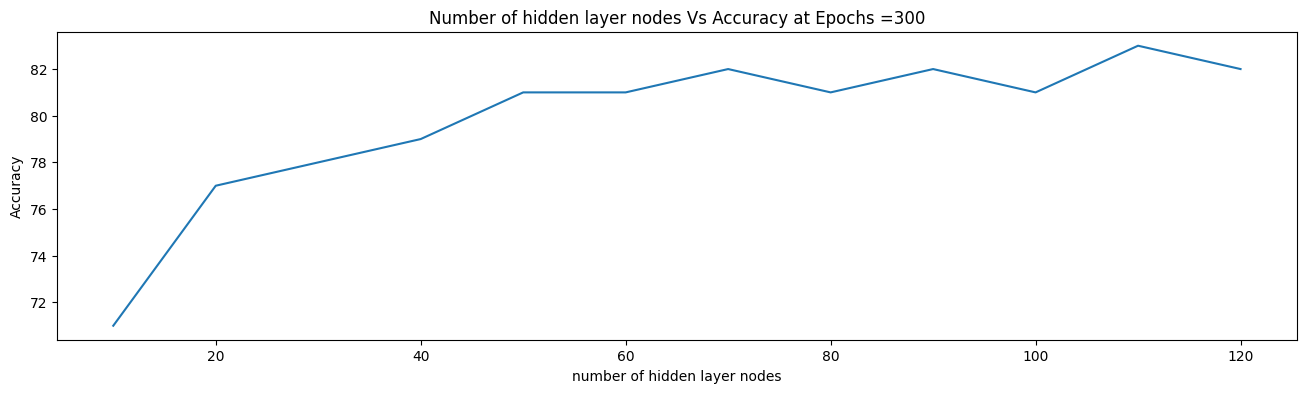

In [36]:
plt.xlabel("number of hidden layer nodes")
plt.ylabel("Accuracy")
plt.plot(n,accuracies)
plt.title('Number of hidden layer nodes Vs Accuracy at Epochs =300')

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

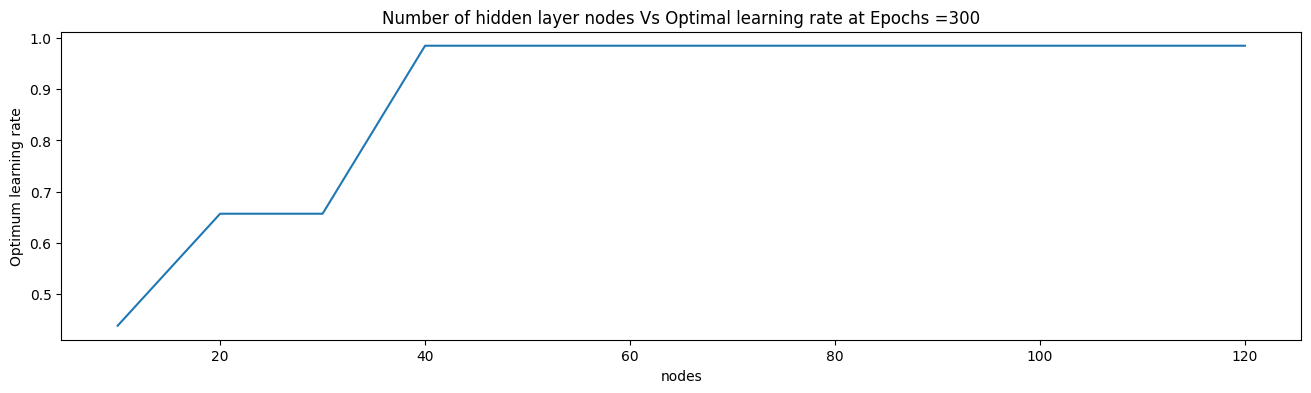

In [37]:
plt.ylabel("Optimum learning rate")
plt.xlabel("nodes")
plt.plot(n,lrates)
plt.title('Number of hidden layer nodes Vs Optimal learning rate at Epochs =300')

Text(0.5, 1.0, 'Learning rate vs Accuracy for 3 second data file (Two layer model scratch,  hidden layer nodes = 110, epochs = 300)')

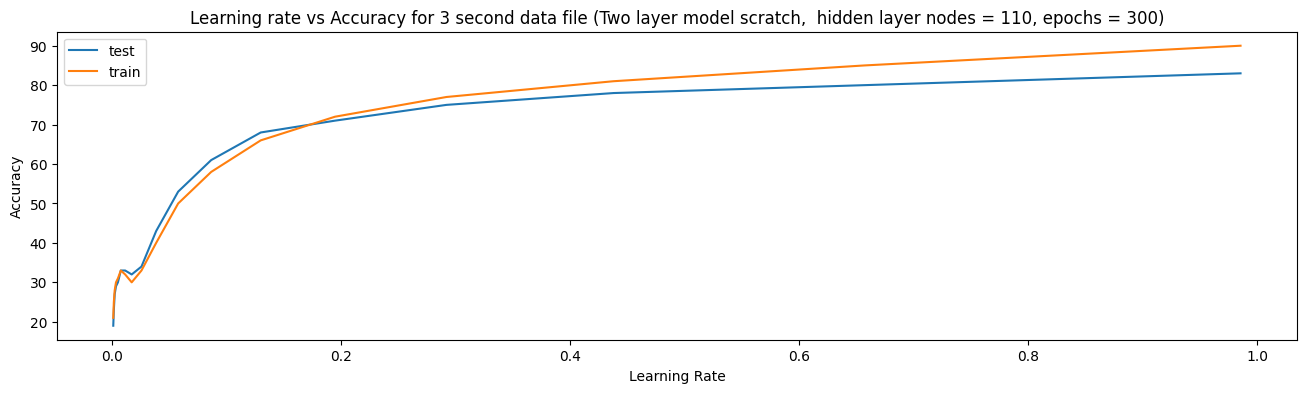

In [38]:
predstt3sec = []
predstr3sec = []
rates = []
learning_rate = 0.001
epochs = 300
nodes =  110
while learning_rate <= 1:
    params = two_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
    ytest3sec = np.array(ytest3sec)
    ytrain3sec = np.array(ytrain3sec)
    predtest3sec = predict(Xtest3sec.T, ytest3sec.T, params)
    predtrain3sec = predict(Xtrain3sec.T, ytrain3sec.T, params)
    predstt3sec.append(predtest3sec)
    predstr3sec.append(predtrain3sec)
    rates.append(learning_rate)
    learning_rate*=1.5
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt3sec)
plt.plot(rates,predstr3sec)
plt.legend(['test','train'])
plt.title('Learning rate vs Accuracy for 3 second data file (Two layer model scratch,  hidden layer nodes = 110, epochs = 300)')
#################Optimal Learning Rate: 0.9852612533569336#####################

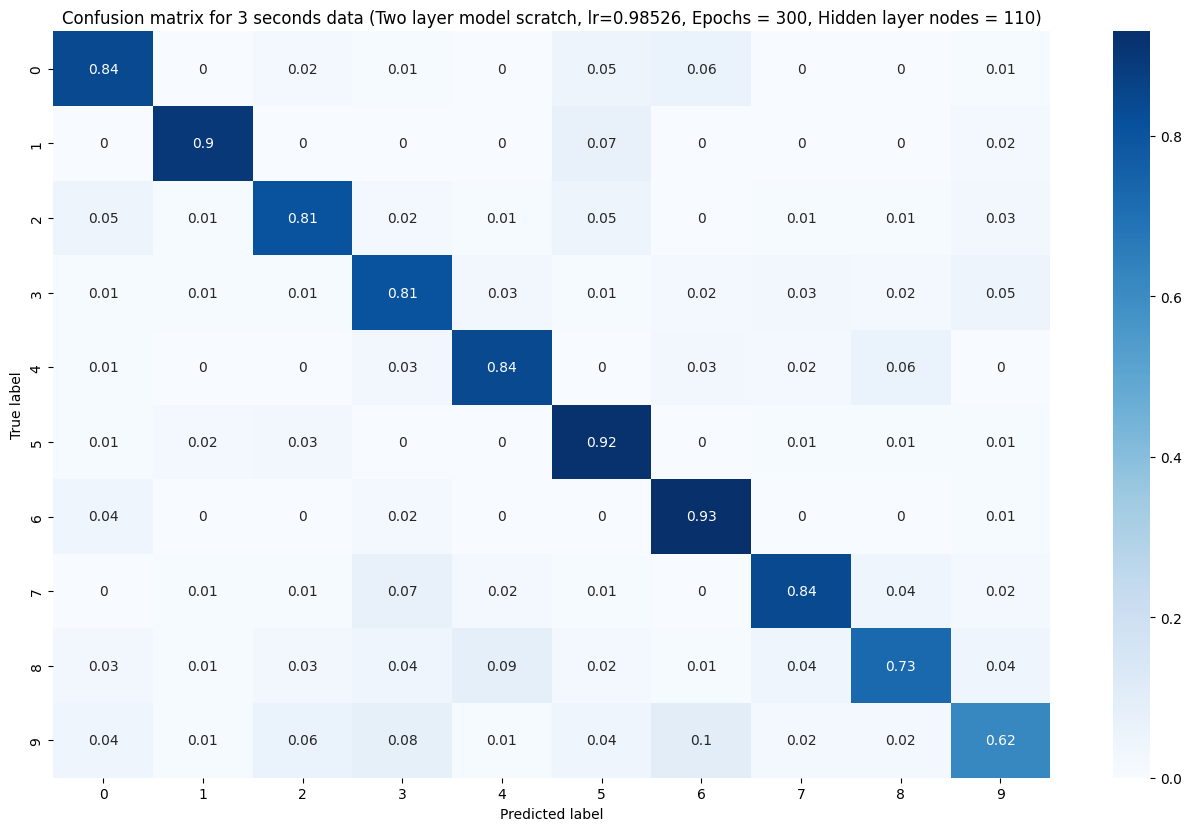

In [39]:
#Optimized parameters for 3 secs data for two layer model
learning_rate = 0.9852612533569336
epochs = 300
nodes =  110
params = two_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
ytest3sec = np.array(ytest3sec)
ytrain3sec = np.array(ytrain3sec)
Ypredicted_test3 = predicted_Y(Xtest3sec.T, ytest3sec.T, params)
Ypredicted_train3 = predicted_Y(Xtrain3sec.T, ytrain3sec.T, params)

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest3sec,Ypredicted_test3,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 3 seconds data (Two layer model scratch, lr=0.98526, Epochs = 300, Hidden layer nodes = 110)')
plt.show()

In [40]:
n = [10,20,30,40,50,60,70,80,90,100,110,120]
accuracies = []
lrates = []
for nodes in n:
    predstt3sec = []
    predstr3sec = []
    rates = []
    learning_rate = 0.001
    epochs = 100
    while learning_rate <= 1:
        params = three_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
        ytest3sec = np.array(ytest3sec)
        ytrain3sec = np.array(ytrain3sec)
        predtest3sec = predict_3Layer(Xtest3sec.T, ytest3sec.T, params)
        predtrain3sec = predict_3Layer(Xtrain3sec.T, ytrain3sec.T, params)
        predstt3sec.append(predtest3sec)
        predstr3sec.append(predtrain3sec)
        rates.append(learning_rate)
        learning_rate*=1.5
    print("Optimal Learning Rate:", rates[np.argmax(predstt3sec)])
    params = three_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes, 10),rates[np.argmax(predstt3sec)], epochs, True)
    predtest3sec = predict_3Layer(Xtest3sec.T, ytest3sec.T, params)
    print("Number of Epochs: ", epochs)
    print("Model used: Two layer model")
    print("Number of hidden layer nodes: ", nodes)
    print("Test accuracy: ", predtest3sec, "%")
    accuracies.append(predtest3sec)
    lrates.append(rates[np.argmax(predstt3sec)])

Optimal Learning Rate: 0.001
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  10
Test accuracy:  9.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  20
Test accuracy:  34.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  30
Test accuracy:  34.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  40
Test accuracy:  49.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  50
Test accuracy:  44.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden layer nodes:  60
Test accuracy:  45.0 %
Optimal Learning Rate: 0.9852612533569336
Number of Epochs:  100
Model used: Two layer model
Number of hidden laye

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Accuracy at Epochs =200')

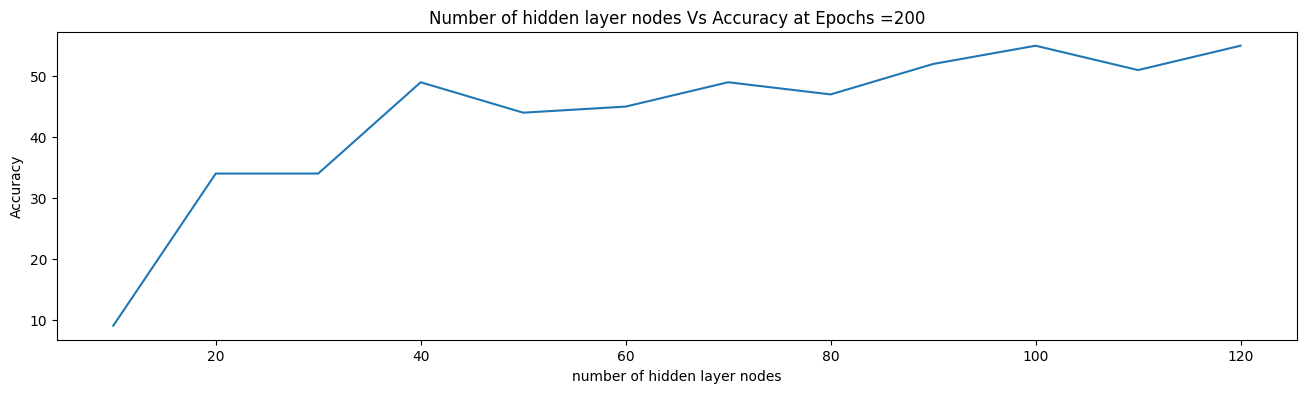

In [41]:
plt.xlabel("number of hidden layer nodes")
plt.ylabel("Accuracy")
plt.plot(n,accuracies)
plt.title('Number of hidden layer nodes Vs Accuracy at Epochs =200')

Text(0.5, 1.0, 'Number of hidden layer nodes Vs Optimal learning rate at Epochs =200')

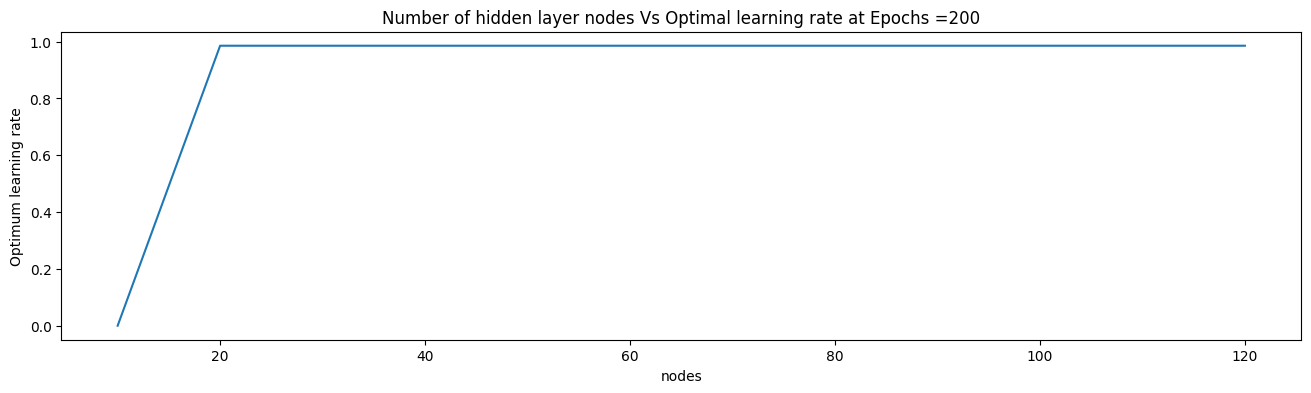

In [42]:
plt.ylabel("Optimum learning rate")
plt.xlabel("nodes")
plt.plot(n,lrates)
plt.title('Number of hidden layer nodes Vs Optimal learning rate at Epochs =200')

Text(0.5, 1.0, 'Learning rate vs Accuracy for 3 second data file (Three layer model scratch,  hidden layer nodes = 120, epochs = 300)')

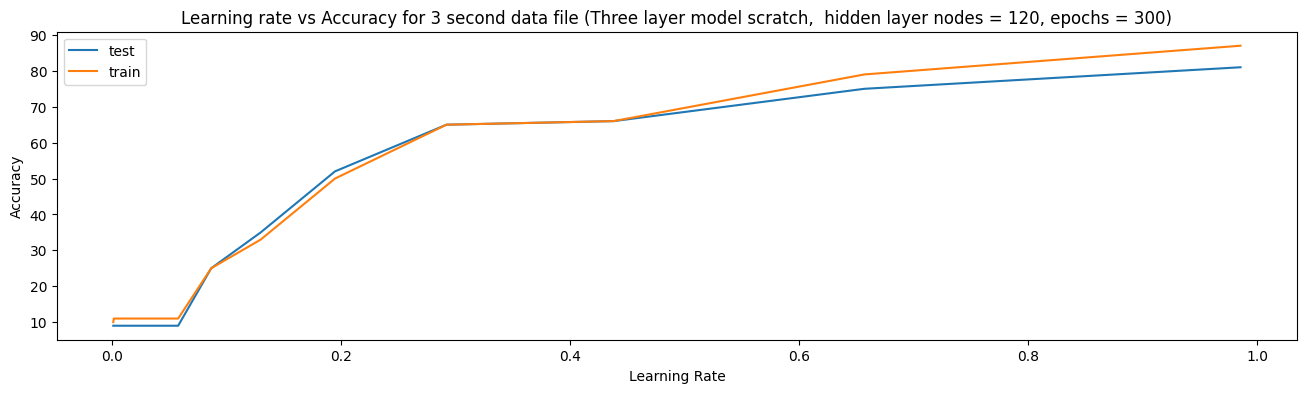

In [43]:
predstt3sec = []
predstr3sec = []
rates = []
learning_rate = 0.001
epochs = 300
nodes =  120
while learning_rate <= 1:
    params = three_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
    ytest3sec = np.array(ytest3sec)
    ytrain3sec = np.array(ytrain3sec)
    predtest3sec = predict_3Layer(Xtest3sec.T, ytest3sec.T, params)
    predtrain3sec = predict_3Layer(Xtrain3sec.T, ytrain3sec.T, params)
    predstt3sec.append(predtest3sec)
    predstr3sec.append(predtrain3sec)
    rates.append(learning_rate)
    learning_rate*=1.5
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt3sec)
plt.plot(rates,predstr3sec)
plt.legend(['test','train'])
plt.title('Learning rate vs Accuracy for 3 second data file (Three layer model scratch,  hidden layer nodes = 120, epochs = 300)')
#################Optimal Learning Rate: 0.9852612533569336#####################

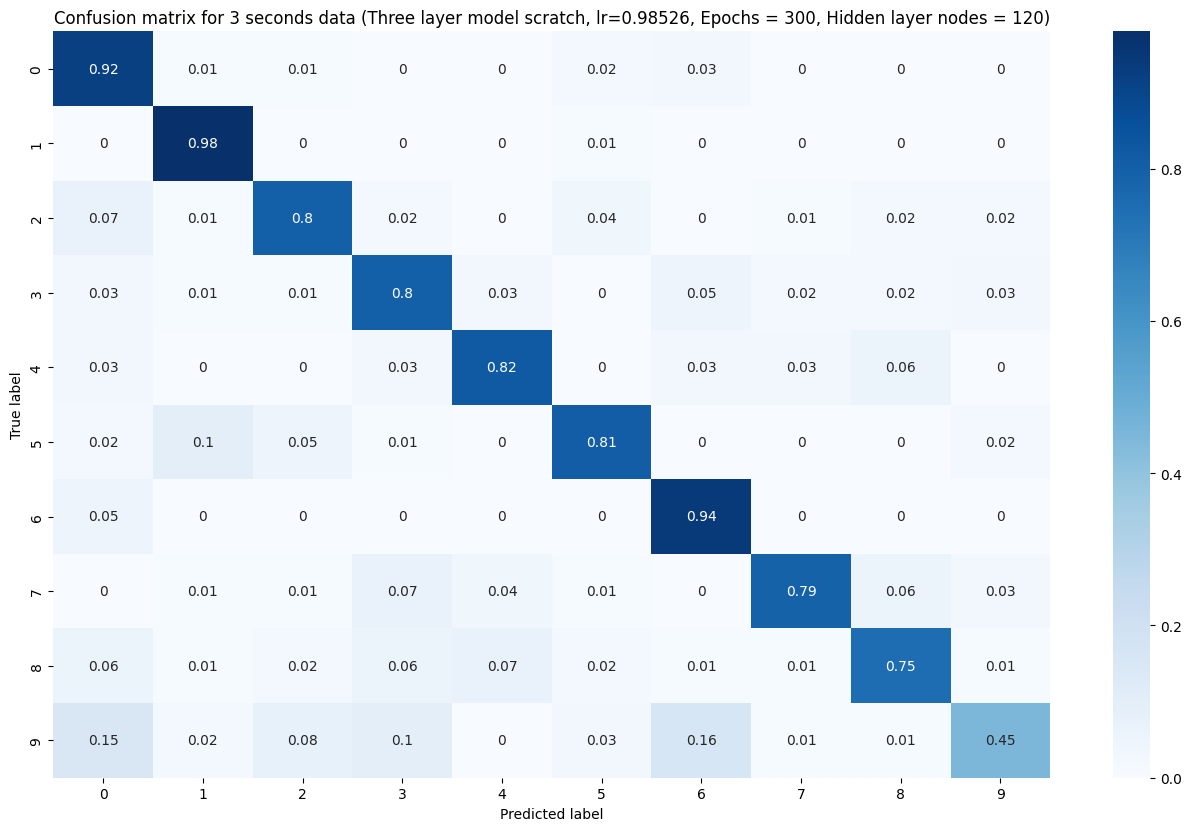

In [44]:
#Optimized parameters for 3 secs data for two layer model
learning_rate = 0.9852612533569336
epochs = 300
nodes =  120
params = three_layer_model(Xtrain3sec.T, ytrain3sec_oh.T, (58, nodes,10), learning_rate, epochs, True)
ytest3sec = np.array(ytest3sec)
ytrain3sec = np.array(ytrain3sec)
Ypredicted_test3 = predicted_Y_3Layer(Xtest3sec.T, ytest3sec.T, params)
Ypredicted_train3 = predicted_Y_3Layer(Xtrain3sec.T, ytrain3sec.T, params)

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest3sec,Ypredicted_test3,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 3 seconds data (Three layer model scratch, lr=0.98526, Epochs = 300, Hidden layer nodes = 120)')
plt.show()

# SKlearn for 3 second data

c:\Python\Python36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


3 Second Dataset:
Test Accuracy:  87.88788788788789 %
Train Accuracy:  99.98331664998331 %
Optimal Learning Rate Based on Test Accuracy:  0.005062500000000001
Number of Iterations:  200


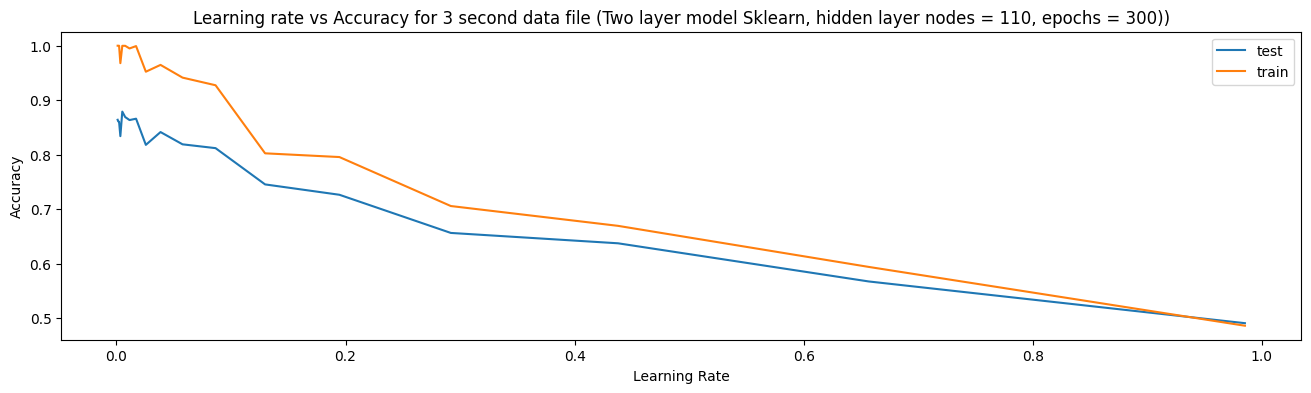

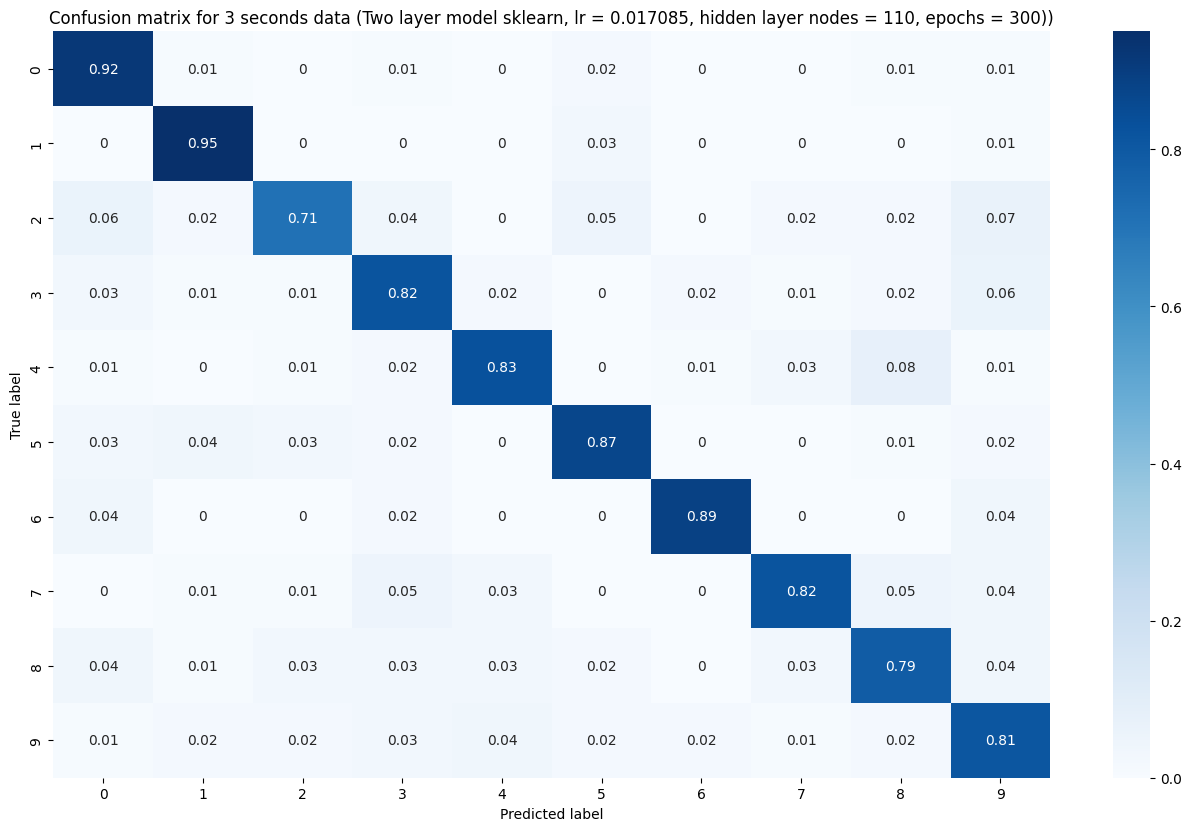

In [45]:
from sklearn.neural_network import MLPClassifier
predstt3sec = []
predstr3sec = []
rates = []
learning_rate = 0.001
while learning_rate <= 1:
    mlp = MLPClassifier(hidden_layer_sizes=(110),learning_rate_init = learning_rate, max_iter = 300)
    mlp.fit(Xtrain3sec,ytrain3sec)
    predtest3sec = mlp.predict(Xtest3sec) 
    predtrain3sec = mlp.predict(Xtrain3sec) 
    predstt3sec.append(accuracy_score(ytest3sec,predtest3sec))
    predstr3sec.append(accuracy_score(ytrain3sec,predtrain3sec))
    rates.append(learning_rate)
    learning_rate*=1.5
    
mlp = MLPClassifier(hidden_layer_sizes=(110),learning_rate_init = rates[np.argmax(predstt3sec)], max_iter = 300)
mlp.fit(Xtrain3sec,ytrain3sec)
prediction = mlp.predict(Xtest3sec)
print("3 Second Dataset:")
print("Test Accuracy: ", predstt3sec[np.argmax(predstt3sec)]*100, "%")
print("Train Accuracy: ", predstr3sec[np.argmax(predstr3sec)]*100, "%")
print("Optimal Learning Rate Based on Test Accuracy: ", rates[np.argmax(predstt3sec)])
print("Number of Iterations: ", str(200))


plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt3sec)
plt.plot(rates,predstr3sec)
plt.legend(['test','train'])

plt.title('Learning rate vs Accuracy for 3 second data file (Two layer model Sklearn, hidden layer nodes = 110, epochs = 300))')



mlp = MLPClassifier(hidden_layer_sizes=(110),learning_rate_init = rates[np.argmax(predstt3sec)], max_iter = 300)
mlp.fit(Xtrain3sec,ytrain3sec)
prediction = mlp.predict(Xtest3sec)


figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest3sec,prediction,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 3 seconds data (Two layer model sklearn, lr = 0.017085, hidden layer nodes = 110, epochs = 300))')
plt.show()

3 Second Dataset:
Test Accuracy:  87.83783783783784 %
Train Accuracy:  99.98331664998331 %
Optimal Learning Rate Based on Test Accuracy:  0.0033750000000000004
Number of Iterations:  300


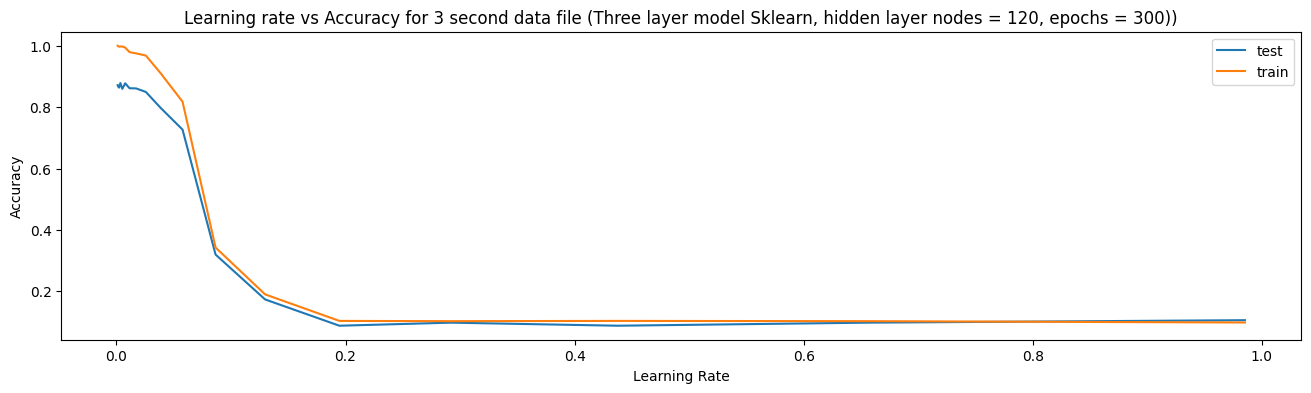

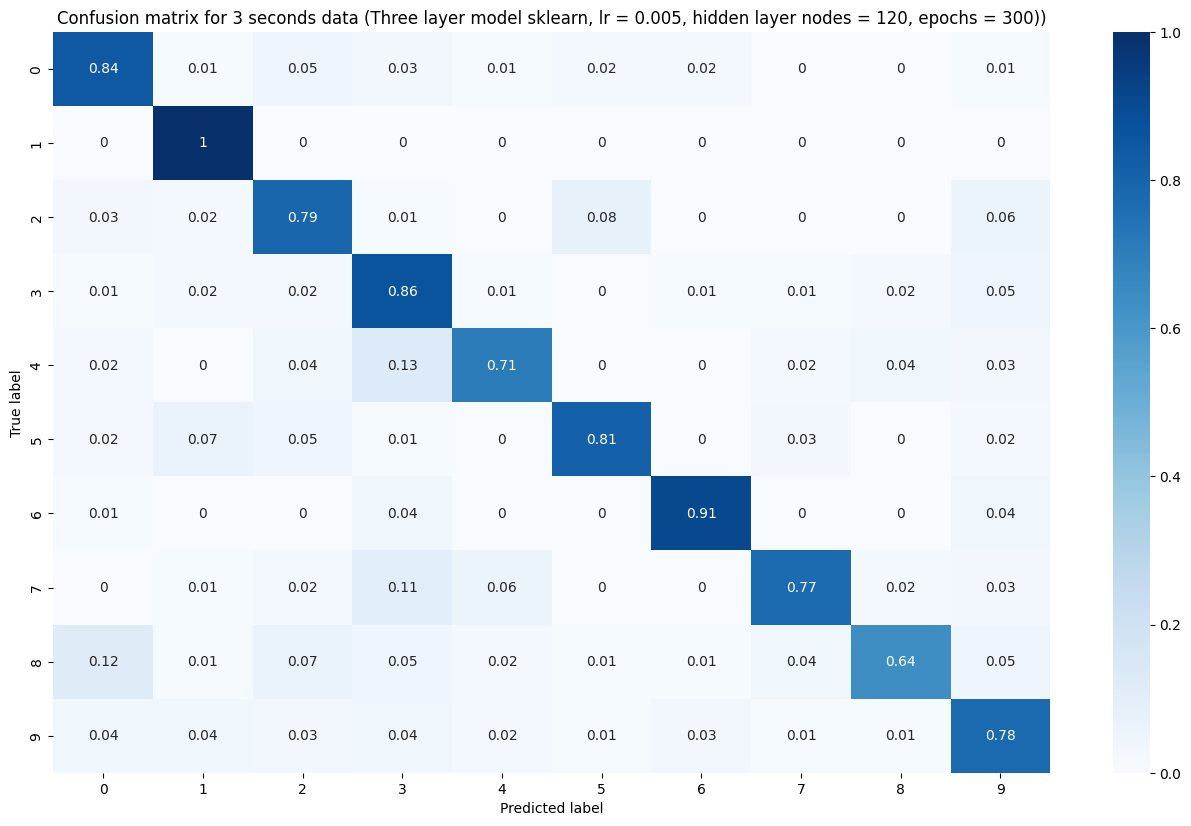

In [46]:
from sklearn.neural_network import MLPClassifier
predstt3sec = []
predstr3sec = []
rates = []
learning_rate = 0.001
while learning_rate <= 1:
    mlp = MLPClassifier(hidden_layer_sizes=(120,120),learning_rate_init = learning_rate, max_iter = 300)
    mlp.fit(Xtrain3sec,ytrain3sec)
    predtest3sec = mlp.predict(Xtest3sec) 
    predtrain3sec = mlp.predict(Xtrain3sec) 
    predstt3sec.append(accuracy_score(ytest3sec,predtest3sec))
    predstr3sec.append(accuracy_score(ytrain3sec,predtrain3sec))
    rates.append(learning_rate)
    learning_rate*=1.5
    
mlp = MLPClassifier(hidden_layer_sizes=(120,120),learning_rate_init = rates[np.argmax(predstt3sec)], max_iter = 300)
mlp.fit(Xtrain3sec,ytrain3sec)
prediction = mlp.predict(Xtest3sec)
print("3 Second Dataset:")
print("Test Accuracy: ", predstt3sec[np.argmax(predstt3sec)]*100, "%")
print("Train Accuracy: ", predstr3sec[np.argmax(predstr3sec)]*100, "%")
print("Optimal Learning Rate Based on Test Accuracy: ", rates[np.argmax(predstt3sec)])
print("Number of Iterations: ", str(300))


plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.plot(rates,predstt3sec)
plt.plot(rates,predstr3sec)
plt.legend(['test','train'])

plt.title('Learning rate vs Accuracy for 3 second data file (Three layer model Sklearn, hidden layer nodes = 120, epochs = 300))')



mlp = MLPClassifier(hidden_layer_sizes=(120,120),learning_rate_init = rates[np.argmax(predstt3sec)], max_iter = 300)
mlp.fit(Xtrain3sec,ytrain3sec)
prediction = mlp.predict(Xtest3sec)


figure = plt.figure(figsize=(13, 8))
cm = confusion_matrix(ytest3sec,prediction,labels = [0,1,2,3,4,5,6,7,8,9])
cm_normalized = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
sns.heatmap(cm_normalized,cmap=plt.cm.Blues,annot= True,xticklabels = [0,1,2,3,4,5,6,7,8,9],yticklabels = [0,1,2,3,4,5,6,7,8,9])

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for 3 seconds data (Three layer model sklearn, lr = 0.005, hidden layer nodes = 120, epochs = 300))')
plt.show()